# 0. Imports and Useful Functions

In [1]:
import pandas as pd
import numpy as np

# Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# ML Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.utils import shuffle
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

import matplotlib.pyplot as plt

import re

from statistics import mode

import seaborn as sns

from scipy.stats import uniform

In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

# 1. Data Read-In and Check

## 1.1. Train Set

In [3]:
train_df = pd.read_csv("data/train.csv")
train_df = shuffle(train_df, random_state=123)
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
172,173,1,3,"Johnson, Miss. Eleanor Ileen",female,1.0,1,1,347742,11.1333,NaN,S
524,525,0,3,"Kassem, Mr. Fared",male,NaN,0,0,2700,7.2292,NaN,C
452,453,0,1,"Foreman, Mr. Benjamin Laventall",male,30.0,0,0,113051,27.7500,C111,C
170,171,0,1,"Van der hoef, Mr. Wyckoff",male,61.0,0,0,111240,33.5000,B19,S
620,621,0,3,"Yasbeck, Mr. Antoni",male,27.0,1,0,2659,14.4542,NaN,C


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 172 to 510
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


#### Age, Cabin, Embarked에서 결측치가 관찰되고 특히 Cabin의 결측치가 많음

In [5]:
train_df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

#### - Unique한 Data 수가 많은 Name, Age, Ticket, Fare, Cabin 에 대해 Grouping 처리가 필요하다 판단됨 
#### - PassengerId는 Feature가 아닌 인덱스로 사용 예정 
#### - Ticket의 경우 CountVectorizer 사용 예정

In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Fare의 분포가 매우 넓어 Fare의 분포 형상과 Outlier의 존재 확인 필요. SibSp(형제/자매/배우자 수)와 Parch(부모/자녀 수)는 가족수로 변경 예정

## 1.2. Test Set

In [7]:
test_df = pd.read_csv("data/test.csv")
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


#### Train Set과 다르게 Fare에서 하나의 결측치가 있음. 결측치 수가 1개이기 때문에 따로 결측치에 대한 Feature화는 진행하지 않음

In [9]:
test_df.nunique()

PassengerId    418
Pclass           3
Name           418
Sex              2
Age             79
SibSp            7
Parch            8
Ticket         363
Fare           169
Cabin           76
Embarked         3
dtype: int64

#### Train Set와 큰 차이 없어 보임

In [10]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


#### Train Set와 큰 차이 없어 보임

# 2. EDA

In [11]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## 2.1. Survived (생존자/희생자 수 비교)

In [12]:
train_df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [13]:
# 생존자와 희생자 간 Feature 분포 확인을 위해 별도 dataframe 준비
train_survived = train_df.query("Survived == 1")
train_perished = train_df.query("Survived == 0")

## 2.2. 생존자/희생자 대상 각 Feature별 분포 비교

#### Unique한 값이 적고 결측치가 없거나 적은 Feature에 대해 분포도 확인

In [14]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']

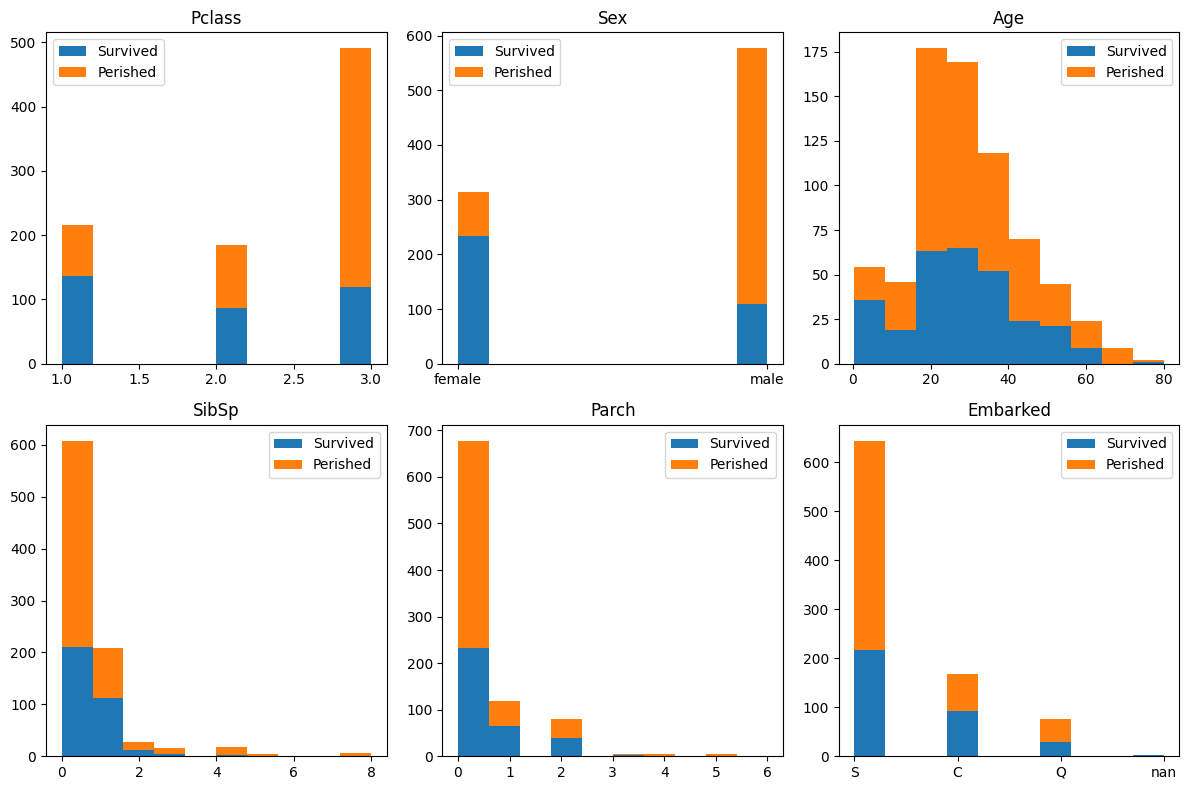

In [15]:
fig, axs = plt.subplots(figsize=(12, 8), nrows=2, ncols=3)
r = 0
c = 0
for feat in features:
    if feat == "Embarked":
        axs[r, c].hist([train_survived[f"{feat}"].astype('str'), train_perished[f"{feat}"].astype('str')], stacked=True)
        axs[r, c].legend(["Survived", "Perished"])
        axs[r, c].set_title(f"{feat}")
    else:
        axs[r, c].hist([train_survived[f"{feat}"], train_perished[f"{feat}"]], stacked=True)
        axs[r, c].legend(["Survived", "Perished"])
        axs[r, c].set_title(f"{feat}")
    if c < 2:
        c += 1
    else:
        r += 1
        c = 0
plt.tight_layout()
plt.show();

#### - Pclass: 3등석에서 희생자가 많음
#### - Sex: 여성의 생존율이 높음
#### - Age: 아이들의 생존율이 높음
#### - SibSp/Parch: 가족 구성원의 수가 많을 수록 생존율이 높음
#### - Embarked: S의 경우 생존율이 낮음

## 2.3. Fare에 대한 분포 확인

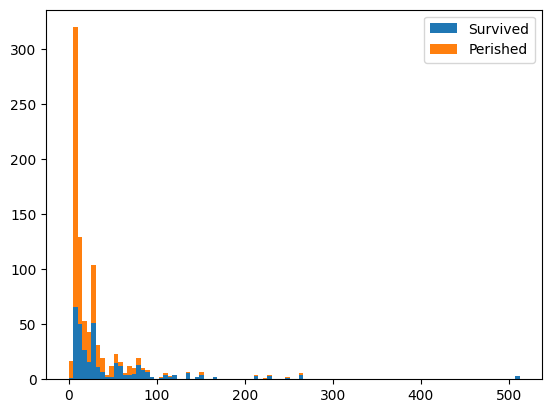

In [16]:
plt.figure()
plt.hist([train_survived["Fare"], train_perished["Fare"]], bins=100, stacked=True)
plt.legend(["Survived", "Perished"])
plt.show();

In [17]:
# 로그 취함 (log(0) 방지를 위해 0.1을 더함)

log_train_survived = train_survived["Fare"] + 0.1
log_train_survived = log_train_survived.apply(np.log)

log_train_perished = train_perished["Fare"] + 0.1
log_train_perished = log_train_perished.apply(np.log)

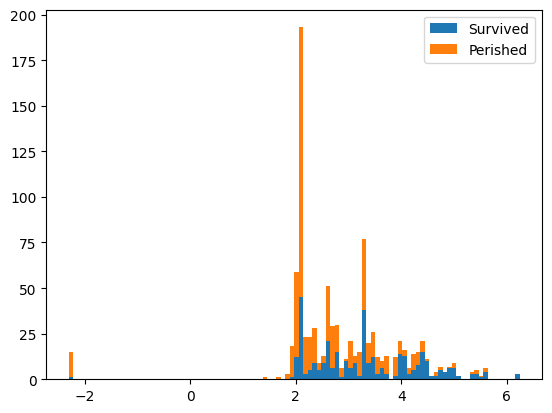

In [18]:
plt.figure()
plt.hist([log_train_survived, log_train_perished], bins=100, stacked=True)
plt.legend(["Survived", "Perished"])
plt.show();

#### 로그화에 따른 큰 장점이 없어 보임

# 3. Data Preprocessing

## 3.1. Data Wrangling

In [19]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [20]:
def preprocess_titanic_data(df: pd.DataFrame):
    """
    Preprocess dataframe including data wrangling and feature engineering
    
    Parameters
    ----------
    df :
        pandas DataFrame

    Returns
    ----------
        preprocessed pandas DataFrame 
    """
    # 0. "PassengerId" Index로 변경
    df.set_index("PassengerId", inplace=True)
    
    # 1. Ticket Class를 Ordinal 변수로 변경
    df.loc[df['Pclass'] == 1, 'Pclass'] = "1st"
    df.loc[df['Pclass'] == 2, 'Pclass'] = "2nd"
    df.loc[df['Pclass'] == 3, 'Pclass'] = "3rd"
    
    # 2. 결측치 처리
    # 2.1. 결측치 유/무 여부를 Feature로 적용
    df['missing_Age'] = df['Age'].isna()    
    df['missing_Cabin'] = df['Cabin'].isna()
    df['missing_Embarked'] = df['Embarked'].isna()
    # 2.2. 결측치 처리 
    df.loc[df['Age'].isna(), 'Age'] = np.mean(df['Age'])   # 평균 나이 사용
    df.loc[df['Cabin'].isna(), 'Cabin'] = "missing"   # "missing"으로 표시
    df.loc[df['Fare'].isna(), 'Fare'] = mode(df['Fare'])   # 가장 많은 Fare값을 사용
    df.loc[df['Embarked'].isna(), 'Embarked'] = mode(df['Embarked'])   # 가장 많은 Embarked값을 사용
    
    # 3. "Cabin"열 분류
    df['Cabin'] = df['Cabin'].str.replace("^A{1}.*", "A", regex=True)
    df['Cabin'] = df['Cabin'].str.replace("^B{1}.*", "B", regex=True)
    df['Cabin'] = df['Cabin'].str.replace("^C{1}.*", "C", regex=True)
    df['Cabin'] = df['Cabin'].str.replace("^D{1}.*", "D", regex=True)
    df['Cabin'] = df['Cabin'].str.replace("^E{1}.*", "E", regex=True)
    df['Cabin'] = df['Cabin'].str.replace("^F{1}.*", "F", regex=True)
    df['Cabin'] = df['Cabin'].str.replace("^G{1}.*", "G", regex=True)
    
    # 4. 가족 수 Feature화
    df["n_Family"] = df["SibSp"] + df["Parch"] + 1
    
    # 5. "Age" 분류하여 4개로 Grouping
    df['Age_bin'] = pd.cut(
        df['Age'], 
        bins=[0,12,20,40,120], 
        labels=['Children','Teenage','Adult','Elder']
    )

    # 6. "Fare" 분류하여 6개로 Grouping
    df['Fare_bin'] = pd.cut(
        df['Fare'], 
        bins=[0, 0.1, 7.91, 14.45, 31, 120, 600], 
        labels=['Free', 'Low_fare','median_fare', 'Average_fare','high_fare', 'super_high_fare'],
        include_lowest=True
    )

    # Title Feature화
    df['Title'] = df['Name'].apply(get_title)

    # Title Feature를 3개로 Grouping
    df['Title'] = df['Title'].replace(
        ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 
        'Rare',
        regex=True
    )
    df['Title'] = df['Title'].replace('Mlle', 'Miss', regex=True)
    df['Title'] = df['Title'].replace('Ms', 'Miss', regex=True)
    df['Title'] = df['Title'].replace('Mme', 'Mrs', regex=True)
    
    return df
    

In [21]:
train_df = preprocess_titanic_data(train_df)
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,missing_Age,missing_Cabin,missing_Embarked,n_Family,Age_bin,Fare_bin,Title
PassengerId,,,,,,,,,,,,,,,,,,
173,1,3rd,"Johnson, Miss. Eleanor Ileen",female,1.000000,1,1,347742,11.1333,missing,S,False,True,False,3,Children,median_fare,Miss
525,0,3rd,"Kassem, Mr. Fared",male,29.699118,0,0,2700,7.2292,missing,C,True,True,False,1,Adult,Low_fare,Mr
453,0,1st,"Foreman, Mr. Benjamin Laventall",male,30.000000,0,0,113051,27.7500,C,C,False,False,False,1,Adult,Average_fare,Mr
171,0,1st,"Van der hoef, Mr. Wyckoff",male,61.000000,0,0,111240,33.5000,B,S,False,False,False,1,Elder,high_fare,Mr
621,0,3rd,"Yasbeck, Mr. Antoni",male,27.000000,1,0,2659,14.4542,missing,C,False,True,False,2,Adult,Average_fare,Mr


## 3.2. EDA on Engineered Features

In [22]:
# 생존자와 희생자 간 Feature 분포 확인을 위해 별도 dataframe 준비
train_survived = train_df.query("Survived == 1")
train_perished = train_df.query("Survived == 0")

In [23]:
train_df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'missing_Age', 'missing_Cabin',
       'missing_Embarked', 'n_Family', 'Age_bin', 'Fare_bin', 'Title'],
      dtype='object')

In [24]:
engineered_features = [
    "Pclass", "Cabin", "missing_Age", "missing_Cabin", "missing_Embarked",
    "n_Family", "Age_bin", "Fare_bin", "Title"
]

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


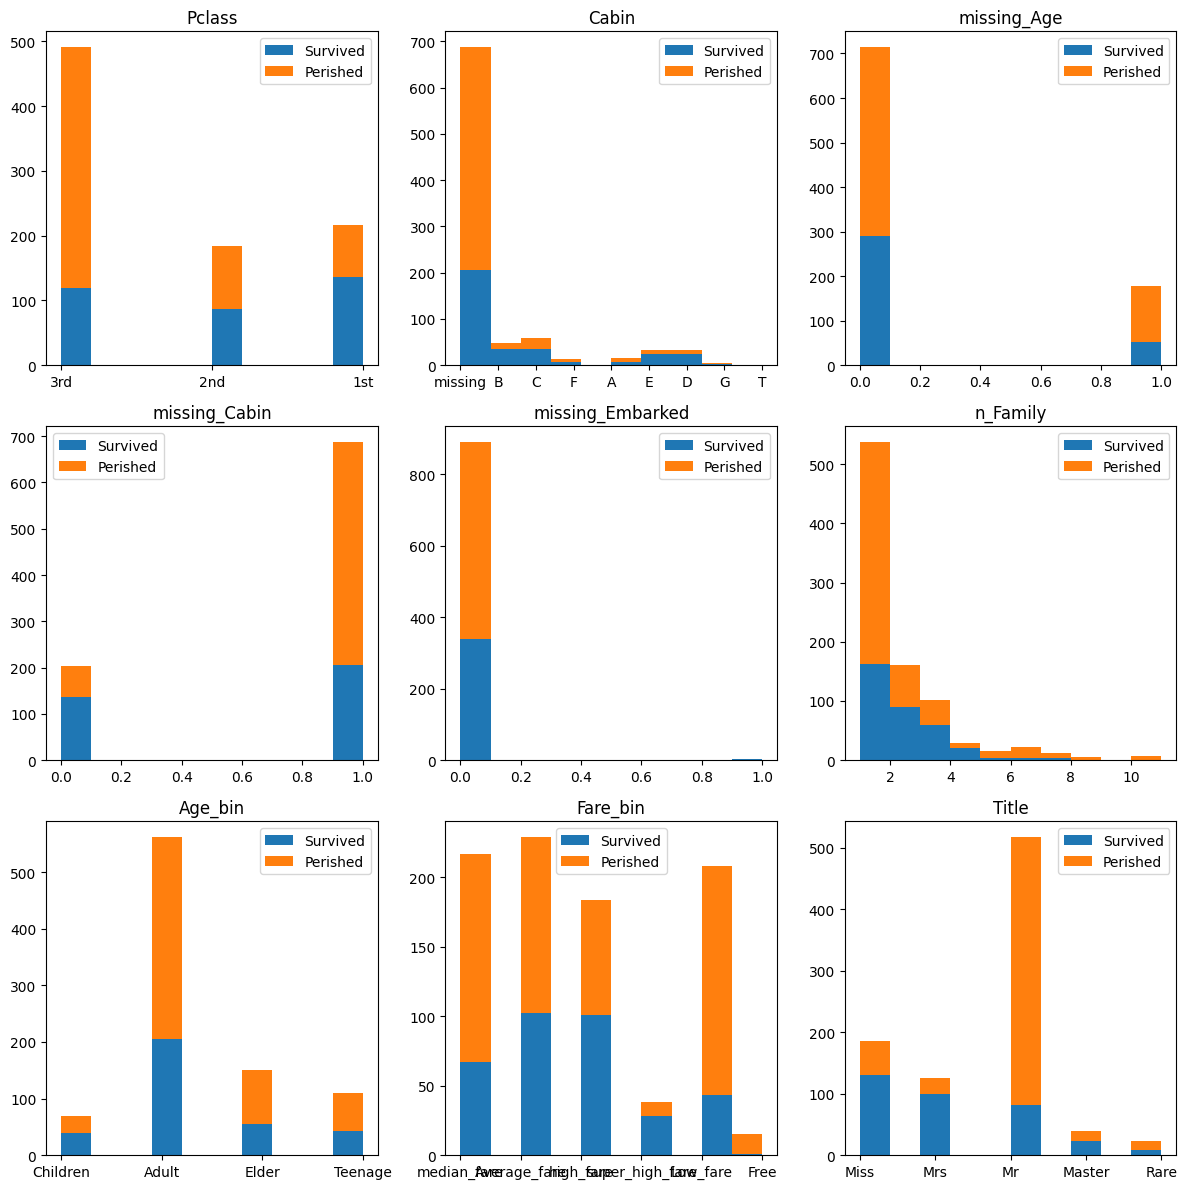

In [25]:
fig, axs = plt.subplots(figsize=(12, 12), nrows=3, ncols=3)
r = 0
c = 0
for feat in engineered_features:
    axs[r, c].hist([train_survived[f"{feat}"], train_perished[f"{feat}"]], stacked=True)
    axs[r, c].legend(["Survived", "Perished"])
    axs[r, c].set_title(f"{feat}")
    if c < 2:
        c += 1
    else:
        r += 1
        c = 0
plt.tight_layout()
plt.show();

#### - Pclass: 등급이 낮아질 수록 생존율 낮아짐
#### - Cabin, missing_Cabin: Cabin 정보가 없을 경우 생존율 낮아짐, missing_Cabin과 Cabin간 교호작용이 있어 missing_Cabin은 Feature에서 제외
#### - missing_Age: Age 정보가 없을 경우 생존율 낮아짐
#### - missing_Embark: Embark가 없는 경우가 너무 적어 비교 어려움
#### - n_Family: 가족 수가 너무 적거나 너무 많을 경우 생존율 낮아짐
#### - Age_bin: Children의 생존율이 높음
#### - Fare_bin: "Free"의 생존율이 매우 낮음, "super_high_fare"의 생존율이 매우 높음
#### - Title: "Mr"의 생존율이 낮음

# 4. Machine Learning

## 4.1. Preprocessing

In [26]:
X_train, y_train = train_df.drop(columns=['Survived']), train_df['Survived']

In [27]:
numeric_features = ["n_Family"]
binary_features = ["Sex", "missing_Age"]
ordinal_features = ["Pclass"]
ordering_ordinal = [
    ["3rd", "2nd", "1st"]
]
ticket_features = "Ticket"
categorical_features = ["Cabin", "Embarked", "Age_bin", "Fare_bin", "Title"]
drop_features = ["Name", "SibSp", "Parch", "Age", "Fare", "missing_Embarked", "missing_Cabin"]

In [28]:
ct = make_column_transformer(
    (
        StandardScaler(),
        numeric_features
    ),
    (
        OneHotEncoder(drop="if_binary", dtype=int, sparse_output=False, handle_unknown="ignore"), 
        binary_features
    ),
    (
        OrdinalEncoder(categories=ordering_ordinal),
        ordinal_features
    ),
    (
        CountVectorizer(ngram_range=(1, 3)),
        ticket_features
    ),
    (
        OneHotEncoder(handle_unknown="ignore"), 
        categorical_features
    ),
    ("drop", drop_features)
)

## 4.2. Cross-Validation

In [29]:
results = {}

In [30]:
pipe_dummy = make_pipeline(ct, DummyClassifier())
pipe_lr = make_pipeline(ct, LogisticRegression(random_state=123))
pipe_dt = make_pipeline(ct, DecisionTreeClassifier(random_state=123))
pipe_rf = make_pipeline(ct, RandomForestClassifier(random_state=123))
pipe_svc = make_pipeline(ct, SVC(random_state=123))
pipe_catb = make_pipeline(ct, CatBoostClassifier(random_state=123, verbose=0))
pipe_lgbm = make_pipeline(ct, LGBMClassifier(random_state=123))
pipe_xgb = make_pipeline(ct, XGBClassifier(random_state=123, verbosity=0))

In [31]:
models = {
    "dummy": pipe_dummy,
    "logistic_regression": pipe_lr,
    "decision_tree": pipe_dt,
    "random_forest": pipe_rf,
    "SVC": pipe_svc,
    "CatBoost": pipe_catb,
    "LightGBM": pipe_lgbm,
    "XGBoost": pipe_xgb,
}

In [32]:
for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True
    )

In [33]:
pd.DataFrame(results)

,dummy,logistic_regression,decision_tree,random_forest,SVC,CatBoost,LightGBM,XGBoost
fit_time,0.016 (+/- 0.002),0.033 (+/- 0.001),0.029 (+/- 0.001),0.608 (+/- 0.017),0.038 (+/- 0.001),4.161 (+/- 0.406),0.079 (+/- 0.007),0.144 (+/- 0.026)
score_time,0.007 (+/- 0.001),0.007 (+/- 0.001),0.007 (+/- 0.001),0.019 (+/- 0.001),0.012 (+/- 0.001),0.010 (+/- 0.001),0.016 (+/- 0.001),0.018 (+/- 0.001)
test_score,0.616 (+/- 0.003),0.843 (+/- 0.039),0.820 (+/- 0.024),0.835 (+/- 0.031),0.835 (+/- 0.025),0.839 (+/- 0.024),0.817 (+/- 0.025),0.815 (+/- 0.028)
train_score,0.616 (+/- 0.001),0.897 (+/- 0.007),0.996 (+/- 0.001),0.996 (+/- 0.001),0.859 (+/- 0.007),0.875 (+/- 0.005),0.896 (+/- 0.007),0.921 (+/- 0.004)


#### `LogisticRegression`, `CatBoost`, `RandomForest`/`SVC`, `DecisionTree` 순으로 cv score가 높음

## 4.3. Feature Importances by `LogisticRegression`

In [34]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['n_Family']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sex', 'missing_Age']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['3rd',
                                                                              '2nd',
                                                                              '1st']]),
                                                  ['Pclass']),
                                                 ('countvectorizer',
                                                  CountVectorizer(ngram_range=(1,
                                                                               3)),
                                                  'Ticket'),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Cabin', 'Embarked',
                                                   'Age_bin', 'Fare_bin',
                                                   'Title']),
                                                 ('drop', 'drop',
                                                  ['Name', 'SibSp', 'Parch',
                                                   'Age', 'Fare',
                                                   'missing_Embarked',
                                                   'missing_Cabin'])])),
                ('logisticregression', LogisticRegression(random_state=123))])

In [35]:
ticket_columns = (pipe_lr
                 .named_steps["columntransformer"]
                 .named_transformers_["countvectorizer"]
                 .get_feature_names_out(ticket_features)
                 .tolist())

In [36]:
catagorical_columns = (pipe_lr
                       .named_steps["columntransformer"]
                       .named_transformers_["onehotencoder-2"]
                       .get_feature_names_out(categorical_features)
                       .tolist())

In [37]:
columns = numeric_features + binary_features + ordinal_features + ticket_columns + catagorical_columns

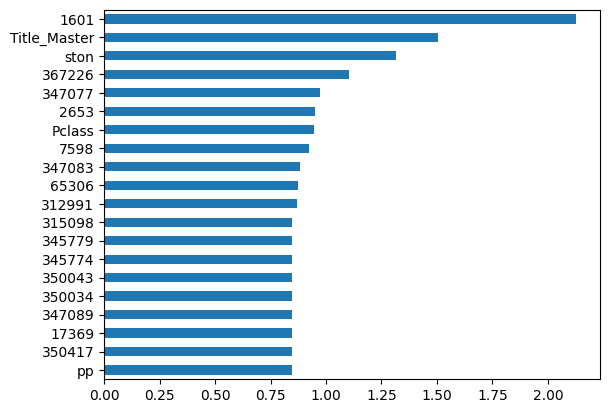

In [38]:
# Top 20 Features
top20_lr = pd.Series(
    pipe_lr.named_steps["logisticregression"].coef_.flatten(), 
    columns
).sort_values(ascending=False).head(20)

top20_lr.plot.barh().invert_yaxis()
plt.show();

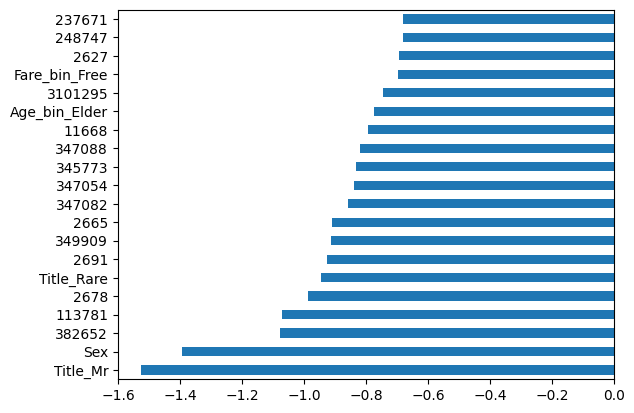

In [39]:
# Bottom 20 Features
top20_lr = pd.Series(
    pipe_lr.named_steps["logisticregression"].coef_.flatten(), 
    columns
).sort_values(ascending=False).tail(20)

top20_lr.plot.barh().invert_yaxis()
plt.show();

## 4.4. Feature Importances by `RandomForest`

In [40]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['n_Family']),
                                                 ('onehotencoder-1',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'int'>,
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Sex', 'missing_Age']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['3rd',
                                                                              '2nd',
                                                                              '1st']]),
                                                  ['Pclass']),
                                                 ('countvectorizer',
                                                  CountVectorizer(ngram_range=(1,
                                                                               3)),
                                                  'Ticket'),
                                                 ('onehotencoder-2',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Cabin', 'Embarked',
                                                   'Age_bin', 'Fare_bin',
                                                   'Title']),
                                                 ('drop', 'drop',
                                                  ['Name', 'SibSp', 'Parch',
                                                   'Age', 'Fare',
                                                   'missing_Embarked',
                                                   'missing_Cabin'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=123))])

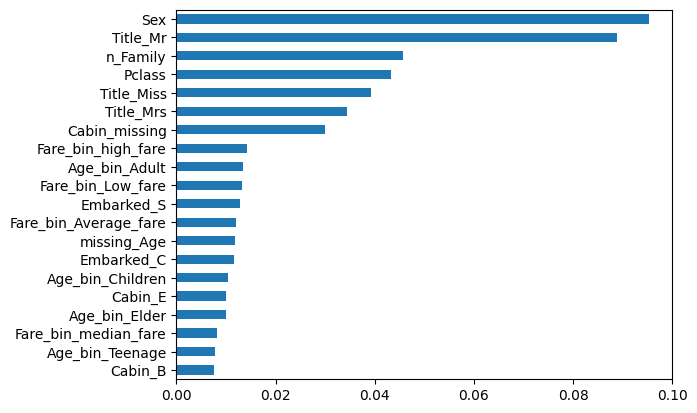

In [41]:
top20_rf = pd.Series(
    pipe_rf.named_steps["randomforestclassifier"].feature_importances_, 
    columns
).sort_values(ascending=False).head(20)
top20_rf.plot.barh().invert_yaxis()
plt.show()

# 5. Prediction

In [42]:
X_test = preprocess_titanic_data(test_df)
X_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,missing_Age,missing_Cabin,missing_Embarked,n_Family,Age_bin,Fare_bin,Title
PassengerId,,,,,,,,,,,,,,,,,
892,3rd,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,missing,Q,False,True,False,1,Adult,Low_fare,Mr
893,3rd,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,missing,S,False,True,False,2,Elder,Low_fare,Mrs
894,2nd,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,missing,Q,False,True,False,1,Elder,median_fare,Mr
895,3rd,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,missing,S,False,True,False,1,Adult,median_fare,Mr
896,3rd,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,missing,S,False,True,False,3,Adult,median_fare,Mrs


## 5.1. Prediction by `LogisticRegression`

In [43]:
pipe_lr.fit(X_train, y_train)
lr_prediction = pipe_lr.predict(X_test)

prediction_by_lr = pd.DataFrame(
    {"PassengerId": X_test.index, "Survived": lr_prediction}
)

In [44]:
prediction_by_lr.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [45]:
prediction_by_lr.to_csv("prediction_by_lr_20230224.csv", index=False)

### Kaggle Score: 0.78229

## 5.2. Prediction by `CatBoost`

In [46]:
pipe_catb.fit(X_train, y_train)
catb_prediction = pipe_catb.predict(X_test)

prediction_by_catb = pd.DataFrame(
    {"PassengerId": X_test.index, "Survived": catb_prediction}
)

In [47]:
prediction_by_catb.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [48]:
prediction_by_catb.to_csv("prediction_by_catb_20230224.csv", index=False)

### Kaggle Score: 0.76794

## 5.3. Prediction by `RandomForest`

In [49]:
pipe_rf.fit(X_train, y_train)
rf_prediction = pipe_rf.predict(X_test)

prediction_by_rf = pd.DataFrame(
    {"PassengerId": X_test.index, "Survived": rf_prediction}
)

In [50]:
prediction_by_rf.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [51]:
prediction_by_rf.to_csv("prediction_by_rf_20230224.csv", index=False)

### Kaggle Score: 0.77511

## 5.4. Prediction by `SVC`

In [52]:
pipe_svc.fit(X_train, y_train)
svc_prediction = pipe_svc.predict(X_test)

prediction_by_svc = pd.DataFrame(
    {"PassengerId": X_test.index, "Survived": svc_prediction}
)

In [53]:
prediction_by_svc.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [54]:
prediction_by_svc.to_csv("prediction_by_svc_20230224.csv", index=False)

### Kaggle Score: 0.7799

## 5.5. Prediction by `DecisionTree`

In [55]:
pipe_dt.fit(X_train, y_train)
dt_prediction = pipe_dt.predict(X_test)

prediction_by_dt = pd.DataFrame(
    {"PassengerId": X_test.index, "Survived": dt_prediction}
)

In [56]:
prediction_by_dt.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [57]:
prediction_by_dt.to_csv("prediction_by_dt_20230224.csv", index=False)

### Kaggle Score: 0.77033

## 5.6. Prediction by Ensemble

In [58]:
predictions = pd.DataFrame(
    {
        "PassengerId": X_test.index,
        "lr_prediction": lr_prediction,
        "catb_prediction": catb_prediction,
        "rf_prediction": rf_prediction,
        "svc_prediction": svc_prediction,
        "dt_prediction": dt_prediction,
    }
)

In [59]:
predictions.head()

,PassengerId,lr_prediction,catb_prediction,rf_prediction,svc_prediction,dt_prediction
0,892,0,0,0,0,0
1,893,1,0,0,1,1
2,894,0,0,0,0,0
3,895,0,0,0,0,0
4,896,1,1,1,1,1


<AxesSubplot: >

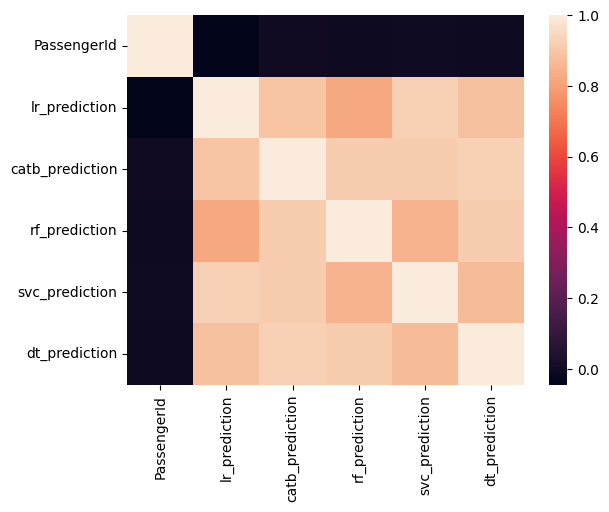

In [60]:
sns.heatmap(predictions.corr())

In [61]:
predictions["Sum"] = predictions.iloc[:, 1:].sum(axis=1)
predictions["Survived"] = predictions["Sum"]//3
predictions.head()

,PassengerId,lr_prediction,catb_prediction,rf_prediction,svc_prediction,dt_prediction,Sum,Survived
0,892,0,0,0,0,0,0,0
1,893,1,0,0,1,1,3,1
2,894,0,0,0,0,0,0,0
3,895,0,0,0,0,0,0,0
4,896,1,1,1,1,1,5,1


In [62]:
prediction_by_ensemble = predictions[["PassengerId", "Survived"]]
prediction_by_ensemble.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [63]:
prediction_by_ensemble.to_csv("prediction_by_ensemble_20230224.csv", index=False)

### Kaggle Score: 0.77511

# 6. Hyperparameter Tunning of `LogisticRegression`

## 6.1. Grid Search

In [64]:
# preprocessing

X_train_enc = ct.fit_transform(X_train)

In [65]:
lr_model = LogisticRegression(random_state=123, max_iter=5000)  # max_iter=5000 to prevent warning

In [66]:
grid = dict(
    solver=['newton-cg', 'lbfgs', 'liblinear'],
    C=uniform(loc=0, scale=4),
    penalty=['l2', 'l1'])

In [67]:
clf = RandomizedSearchCV(
    estimator=lr_model, 
    param_distributions=grid, 
    random_state=123
)

In [68]:
search = clf.fit(X_train_enc, y_train)

C:\Users\johnw\miniconda3\envs\ls_env\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\johnw\miniconda3\envs\ls_env\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\johnw\miniconda3\envs\ls_env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\johnw\miniconda3\envs\ls_env\lib\site-packages\sklearn\linear_model\_logistic.py", l

In [69]:
search.best_params_

{'C': 3.923056793538462, 'penalty': 'l2', 'solver': 'lbfgs'}

## 6.2. New Prediction

In [70]:
pipe_tuned_lr = make_pipeline(
    ct, 
    LogisticRegression(
        C=3.923056793538462,
        penalty='l2',
        solver='lbfgs',
        max_iter=5000,
        random_state=123
    )
)

In [71]:
pipe_tuned_lr.fit(X_train, y_train)
tuned_lr_prediction = pipe_tuned_lr.predict(X_test)

prediction_by_tuned_lr = pd.DataFrame(
    {"PassengerId": X_test.index, "Survived": tuned_lr_prediction}
)

In [72]:
prediction_by_tuned_lr.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [73]:
prediction_by_tuned_lr.to_csv("prediction_by_tuned_lr_20230224.csv", index=False)

### Kaggle Score: 0.7799